In [52]:
# %matplotlib ipympl

In [53]:
import torch
import numpy as np
import importlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from time import sleep, time
import sys
import os
DatasetPath = '../Dataset/' 
# append absolute DasetPath to path
DatasetPath = os.path.abspath(DatasetPath)
sys.path.append(DatasetPath)
import Dataset2 as DS

import pandas as pd

importlib.reload(DS)
DatasetContainer = DS.DatasetContainer
ProcessingDatasetContainer = DS.ProcessingDatasetContainer

def PLTParams(figsize = [10,10]):
    plt.rcParams['figure.figsize']=figsize
    plt.rcParams['font.size']=15
PLTParams()



sys.path.append(os.path.abspath('../CherenkovFraction/'))

# Add the ignore warnings
import warnings
warnings.filterwarnings("ignore")

# hostname = os.uname()
# if 'tedtop' in hostname: plt.style.use('/home/fedor-tairli/work/MPLStylefiles/Vscode_DarkModern_Invisible.mplstyle')


In [54]:
def IndexToXY(indices,return_tensor=False):
    indices = indices -1
    Xs = indices//22
    Ys = indices%22
    if return_tensor: return Xs.int(),Ys.int()
    else:             return Xs.int().tolist(),Ys.int().tolist()



#### Import Datasets

In [55]:
DataPath = os.path.abspath('../Data/Proccessed/')
print('DataPath:',DataPath)

DataPath: /home/fedor-tairli/work/CDEs/Data/Proccessed


In [56]:
# Importing Dataset
# Cause it takes a while to lad this thing introduce a check if its already laoded into globals
CheckGlobals = True 
LoadTraces = True

if CheckGlobals: 
    if 'Dataset' in globals():
        print('Dataset already loaded')
        if len(Dataset.Event_level_keys.keys())<1:
            print('Dataset Event_level_keys is None, reloading Dataset')
            Dataset.Load(DataPath,'CDEsDataset' ,LoadTraces=LoadTraces)
    else:
        print('Loading Dataset')
        Dataset = DatasetContainer()
        Dataset.Load(DataPath,'CDEsDataset' ,LoadTraces=LoadTraces)

# Unfuck the Dataset Keys, cuase the EventID string should have a capital D....
if 'EventId_1/2' in Dataset.Event_level_keys.keys():
    Dataset.Event_level_keys['EventID_1/2'] = Dataset.Event_level_keys.pop('EventId_1/2')
    Dataset.Event_level_keys['EventID_2/2'] = Dataset.Event_level_keys.pop('EventId_2/2')
    print('Replaced the EventID Keys, with proper ones')
else:
    print('EventID Keys already replaced')

Dataset already loaded
EventID Keys already replaced


In [57]:
print('Event level keys:')
for key in Dataset.Event_level_keys.keys(): print('    ',key)
print('Pixel level keys:')
for key in Dataset.Pixel_level_keys.keys(): print('    ',key)

Event level keys:
     EventID_1/2
     EventID_2/2
     Rec_Level
     Event_Class
     Primary
     Gen_LogE
     Gen_CosZenith
     Gen_Xmax
     Gen_dEdXmax
     Gen_SDPPhi
     Gen_SDPTheta
     Gen_Chi0
     Gen_Rp
     Gen_T0
     Gen_CoreEyeDist
     Gen_CherenkovFraction
     Rec_LogE
     Rec_CosZenith
     Rec_Xmax
     Rec_dEdXmax
     Rec_SDPPhi
     Rec_SDPTheta
     Rec_Chi0
     Rec_Rp
     Rec_T0
     Rec_CoreEyeDist
     Rec_CherenkovFraction
Pixel level keys:
     PixelID
     TelID
     EyeID
     Status
     Charge
     Theta
     Phi
     TimeOffset
     PulseStart
     PulseCentroid
     PulseStop


In [58]:
AllPossiblePixelDirections = pd.read_csv('../ReadingData/camera_view_table_with_HEAT_down.txt',sep=' ',header=None,names = ['EyeID','TelID','PixID','Theta','Phi'])

In [59]:
AllPossiblePixelDirections.head()

,EyeID,TelID,PixID,Theta,Phi
0,1,1,1,1.61140,358.419
1,1,1,2,2.86980,359.174
2,1,1,3,4.13764,358.434
3,1,1,4,5.38773,359.205
4,1,1,5,6.66357,358.476


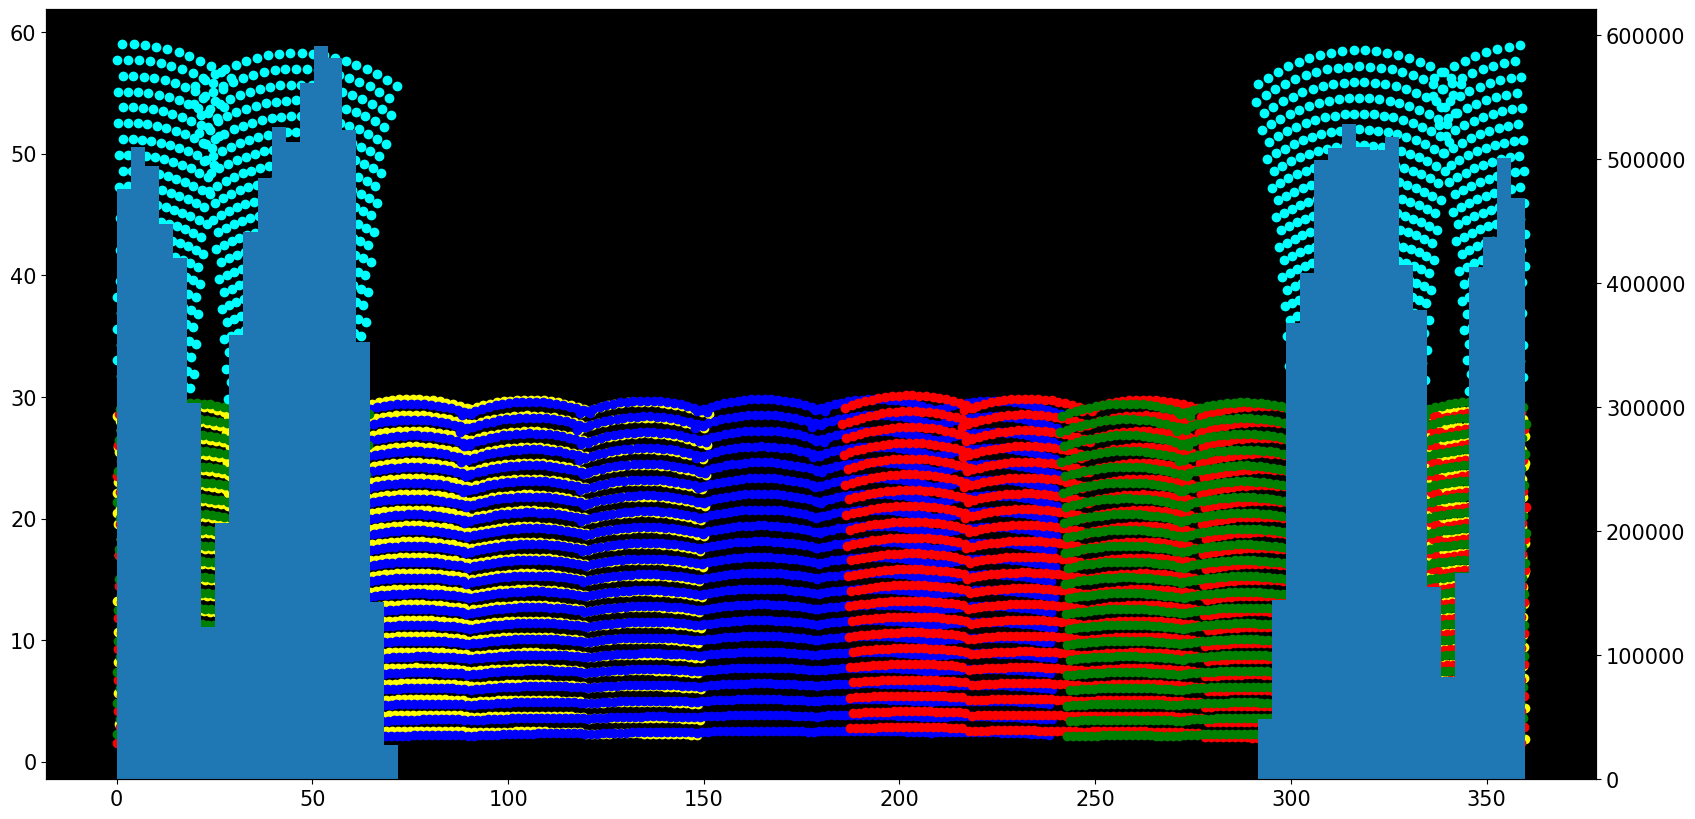

In [60]:
colors = ['yellow','blue','red','green','cyan']
plt.figure(figsize = [20,10])
plt.gca().set_facecolor('black')
for iEye in range(1,6):
    Mask = AllPossiblePixelDirections.EyeID == iEye
    Thetas = AllPossiblePixelDirections.Theta[Mask]
    Phis   = AllPossiblePixelDirections.Phi[Mask]
    plt.scatter(Phis,Thetas,c = colors[iEye-1])
    
ax2 = plt.gca().twinx()
CO_BackwallAngle = 243.0219
HE_BackwallAngle = 273.0
AllThetas = Dataset.get_pixel_values('Theta')
# plt.hist(AllThetas,bins=100)
AllPhis   = Dataset.get_pixel_values('Phi')
X = AllPhis+HE_BackwallAngle
X[X>360] -= 360
ax2.hist(X,bins=100)
plt.show()

#### XmaxEnergy Normalisations


Mean Xmax: 591.5311
STD Xmax: 72.64725


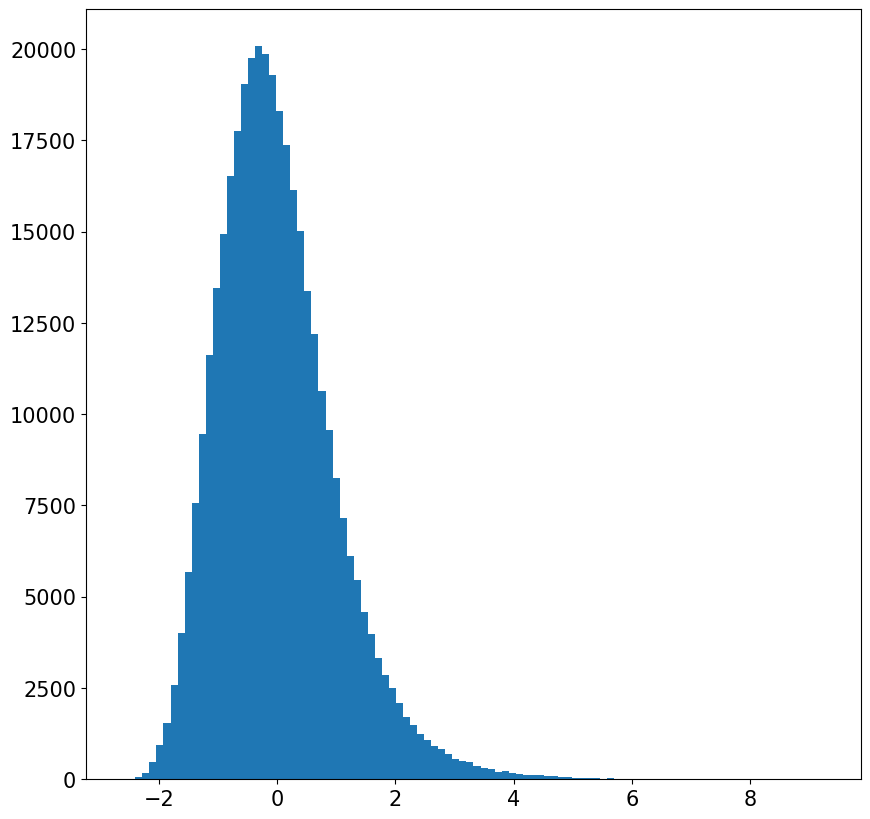

In [61]:
All_Xmax = Dataset.get_values('Gen_Xmax').numpy()

Mean_Xmax = np.mean(All_Xmax)
STD_Xmax  = np.std(All_Xmax)

print('Mean Xmax:',Mean_Xmax)
print('STD Xmax:',STD_Xmax)
# Normalise Xmax to 1000 g/cm^2
X = (All_Xmax - Mean_Xmax)/STD_Xmax

plt.figure(figsize = (10,10))
plt.hist(X,bins=100)
plt.show()

Mean Energy: 16.148266
STD Energy: 0.4755162


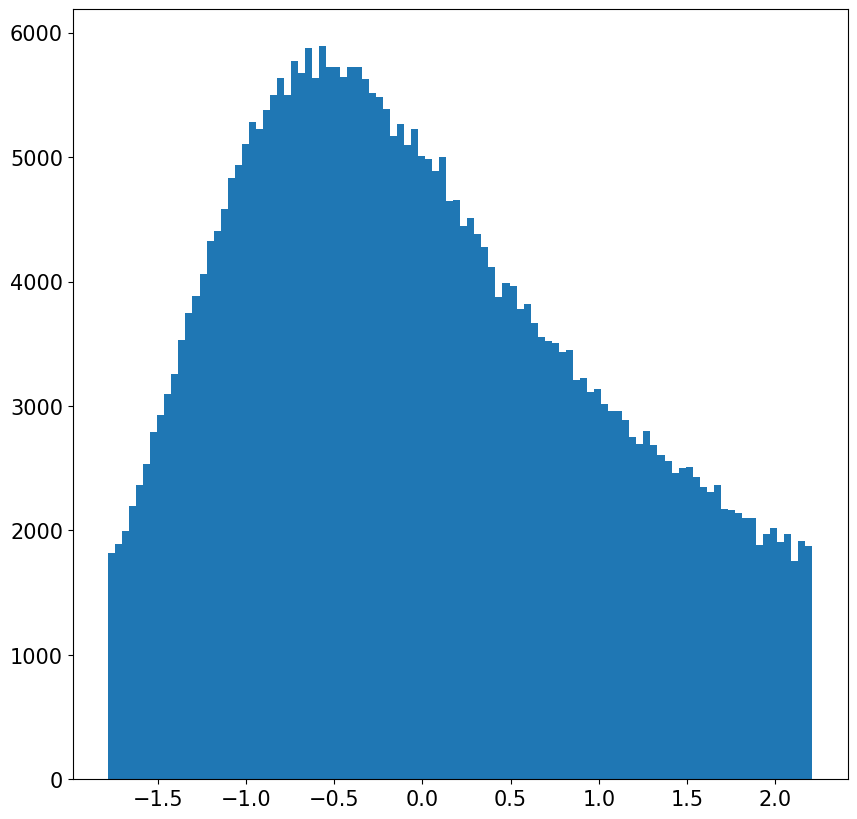

In [381]:
All_Energy = Dataset.get_values('Gen_LogE').numpy()

Energy_Mean = np.mean(All_Energy)
Energy_STD  = np.std(All_Energy)
print('Mean Energy:',Energy_Mean)
print('STD Energy:',Energy_STD)
X = (All_Energy - Energy_Mean)/Energy_STD

plt.figure(figsize = (10,10))
plt.hist(X,bins=100)
plt.show()

In [63]:
# Produce the truncated Colormap for the shower axis
from matplotlib.colors import LinearSegmentedColormap

# Create a truncated version of the plasma colormap (first 90%)
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = LinearSegmentedColormap.from_list(
        f'truncated_{cmap.name}', 
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap

# Original plasma colormap
plasma = plt.get_cmap('plasma_r')

# Truncated colormap: first 90%
truncated_plasma = truncate_colormap(plasma, 0.05, 1)


(-1.783883810043335, 2.211775064468384)

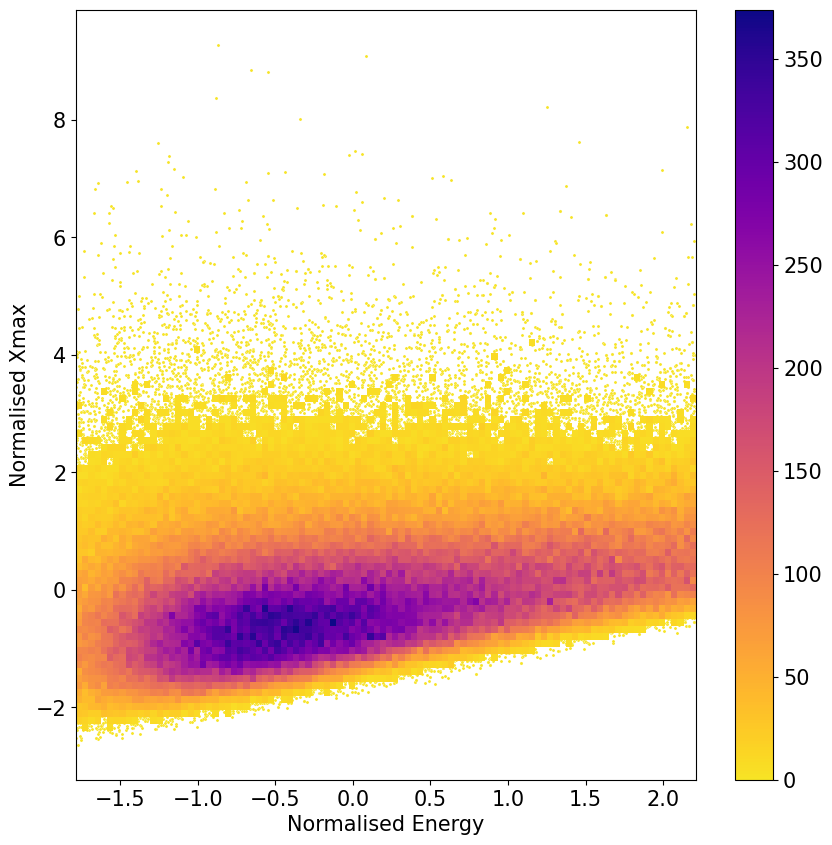

In [64]:
All_Xmax = Dataset.get_values('Gen_Xmax').numpy()
All_Energy = Dataset.get_values('Gen_LogE').numpy()


Normalise = True
if Normalise:
    X = (All_Energy - Energy_Mean)/Energy_STD
    Y = (All_Xmax - Mean_Xmax)/STD_Xmax
    Xlabel = 'Normalised Energy'
    Ylabel = 'Normalised Xmax'
else:

    X = All_Energy
    Y = All_Xmax
    Xlabel = 'Energy (PeV)'
    Ylabel = 'Xmax (g/cm^2)'


plt.figure(figsize = (10,10))
sns.scatterplot(x=X, y=Y, color = truncated_plasma(0.0), s=5)
sns.histplot(x=X, y=Y, bins=100,cmap = truncated_plasma, cbar=True, pthresh=0.01)
plt.xlabel(Xlabel)
plt.ylabel(Ylabel)

# Oonvert Xticks to EeV

if Normalise:
    pass
else:
    Xticks = plt.xticks()[0][::2]
    plt.xticks(ticks=Xticks)
    Xticks = [f'{10**(x-15):.1f}' for x in Xticks]
    plt.xticks(plt.xticks()[0],Xticks)

plt.xlim(min(X),max(X))
    

(15.300000190734863, 17.200000762939453)

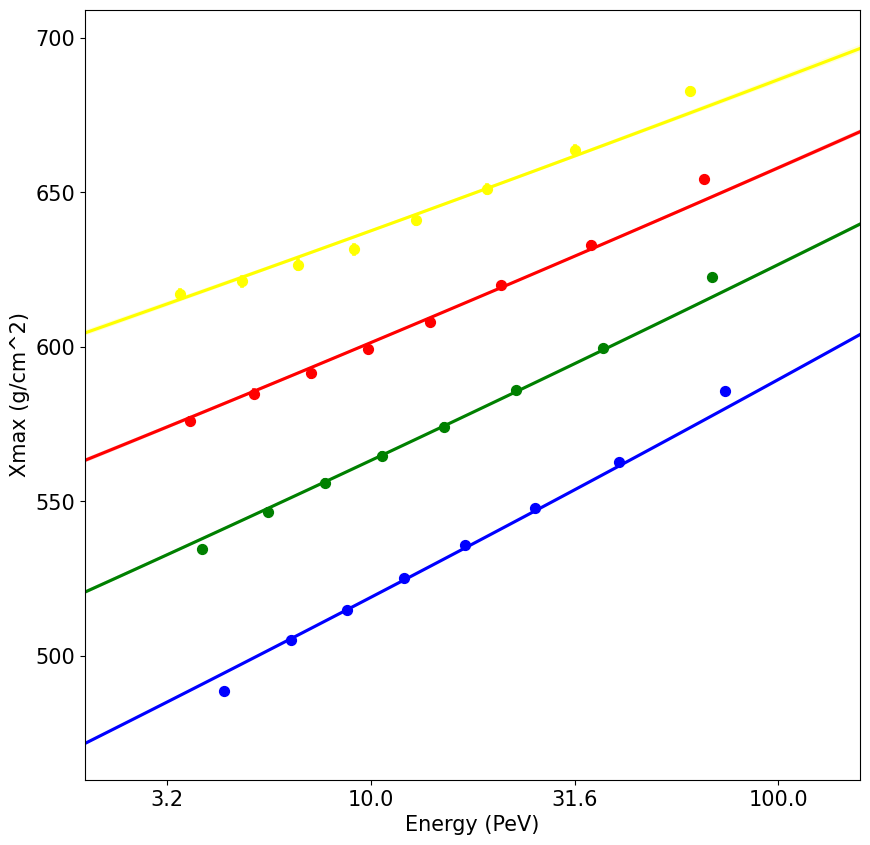

In [65]:
All_Xmax = Dataset.get_values('Gen_Xmax').numpy()
All_Energy = Dataset.get_values('Gen_LogE').numpy()
ALL_Primaries = Dataset.get_values('Primary').numpy()
# [ 2004.  2212.  7014. 26056.] primaries, make them equal to 0,1,2,3
PrimaryColorDict = {2004:'red', 2212:'yellow', 7014:'green', 26056:'blue'}




Normalise = False
if Normalise:
    X = (All_Energy - Energy_Mean)/Energy_STD
    Y = (All_Xmax - Mean_Xmax)/STD_Xmax
    Xlabel = 'Normalised Energy'
    Ylabel = 'Normalised Xmax'
else:

    X = All_Energy
    Y = All_Xmax
    Xlabel = 'Energy (PeV)'
    Ylabel = 'Xmax (g/cm^2)'


plt.figure(figsize = (10,10))
for iPrimary in np.unique(ALL_Primaries):
    Mask = ALL_Primaries == iPrimary
    # plt.scatter(X[Mask], Y[Mask], c=PrimaryColorDict[iPrimary], s=1, label=f'Primary {iPrimary}')
    # use seaborn to plot the averages in each primary in 8 bins
    sns.regplot(x=X[Mask], y=Y[Mask], color=PrimaryColorDict[iPrimary], x_estimator=np.mean, x_bins=8,order = 2)
# sns.scatterplot(x=X, y=Y, c = ALL_Primaries, s=1)
plt.xlabel(Xlabel)
plt.ylabel(Ylabel)

# Oonvert Xticks to EeV

if Normalise:
    pass
else:
    Xticks = plt.xticks()[0][::2]
    plt.xticks(ticks=Xticks)
    Xticks = [f'{10**(x-15):.1f}' for x in Xticks]
    plt.xticks(plt.xticks()[0],Xticks)

plt.xlim(min(X),max(X))
    

In [74]:
Event.Pixel_level_keys

{'PixelID': 0,
 'TelID': 1,
 'EyeID': 2,
 'Status': 3,
 'Charge': 4,
 'Theta': 5,
 'Phi': 6,
 'TimeOffset': 7,
 'PulseStart': 8,
 'PulseCentroid': 9,
 'PulseStop': 10}

N: 277012
Event Energy: 16.89 Lg(E/eV)
Event Xmax: 600.07 g/cm^2
Event Primary: 2004.0


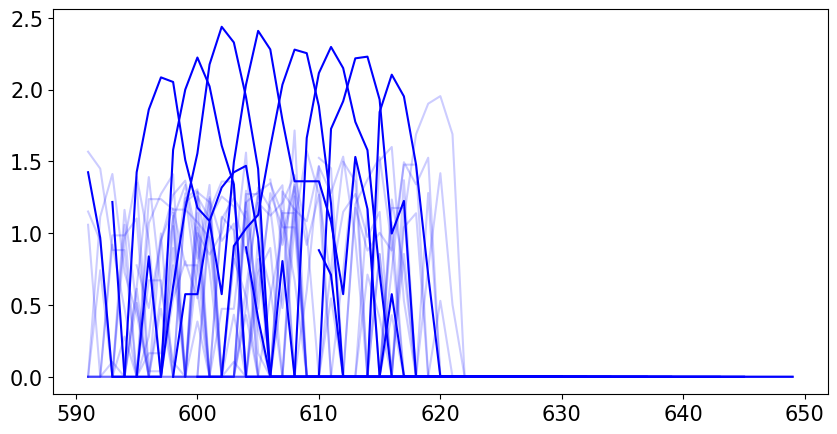

In [380]:
N = np.random.randint(len(Dataset))
print('N:',N)

Event = Dataset.get_event_by_index(N)

print(f'Event Energy: {Event.get_value("Gen_LogE"):.2f} Lg(E/eV)')
print(f'Event Xmax: {Event.get_value("Gen_Xmax"):.2f} g/cm^2')
print(f'Event Primary: {Event.get_value("Primary")}')

PulseStarts = Event.get_pixel_values('PulseStart').numpy()
Traces = torch.log10(torch.clip(Event.get_trace_values(),0)+1).numpy()
Status = Event.get_pixel_values('Status').numpy()
iPix_MaxCharge = torch.argmax(Event.get_pixel_values('Charge')).item()

iPix_MaxCharge_PulseStart = PulseStarts[iPix_MaxCharge]

PulseStarts_Mask = np.abs(PulseStarts - iPix_MaxCharge_PulseStart) < 40

PulseStarts = PulseStarts[PulseStarts_Mask]
Traces = Traces[PulseStarts_Mask,:]
Status = Status[PulseStarts_Mask]


plt.figure(figsize = (10,5))
for i in range(len(PulseStarts)):
    TimeBins = np.arange(40)+PulseStarts[i]
    if Status[i] >0: plt.plot(TimeBins, Traces[i,:],color = 'blue')
    else: plt.plot(TimeBins, Traces[i,:],color ='blue',alpha=0.2)






(array([6.797830e+05, 7.498160e+05, 8.262950e+05, 9.100190e+05,
        1.006198e+06, 1.115614e+06, 1.239448e+06, 1.379693e+06,
        1.535448e+06, 1.711077e+06, 1.900030e+06, 2.094488e+06,
        2.295581e+06, 2.497324e+06, 2.724952e+06, 2.992384e+06,
        3.297624e+06, 3.618508e+06, 3.920795e+06, 4.233713e+06,
        4.582692e+06, 4.922424e+06, 5.239667e+06, 5.560320e+06,
        5.834522e+06, 6.068798e+06, 6.231080e+06, 6.317931e+06,
        6.304675e+06, 6.178687e+06, 5.947727e+06, 5.598013e+06,
        5.147554e+06, 4.621699e+06, 4.050295e+06, 3.461653e+06,
        2.901940e+06, 2.398099e+06, 1.974003e+06, 1.633152e+06,
        1.382131e+06, 1.197441e+06, 1.067810e+06, 9.812720e+05,
        9.169330e+05, 8.642590e+05, 8.218320e+05, 7.786680e+05,
        7.394620e+05, 7.005820e+05, 6.568770e+05, 6.161330e+05,
        5.761110e+05, 5.358150e+05, 4.992760e+05, 4.619190e+05,
        4.259040e+05, 3.916380e+05, 3.597640e+05, 3.301890e+05,
        3.023060e+05, 2.769230e+05, 2.54

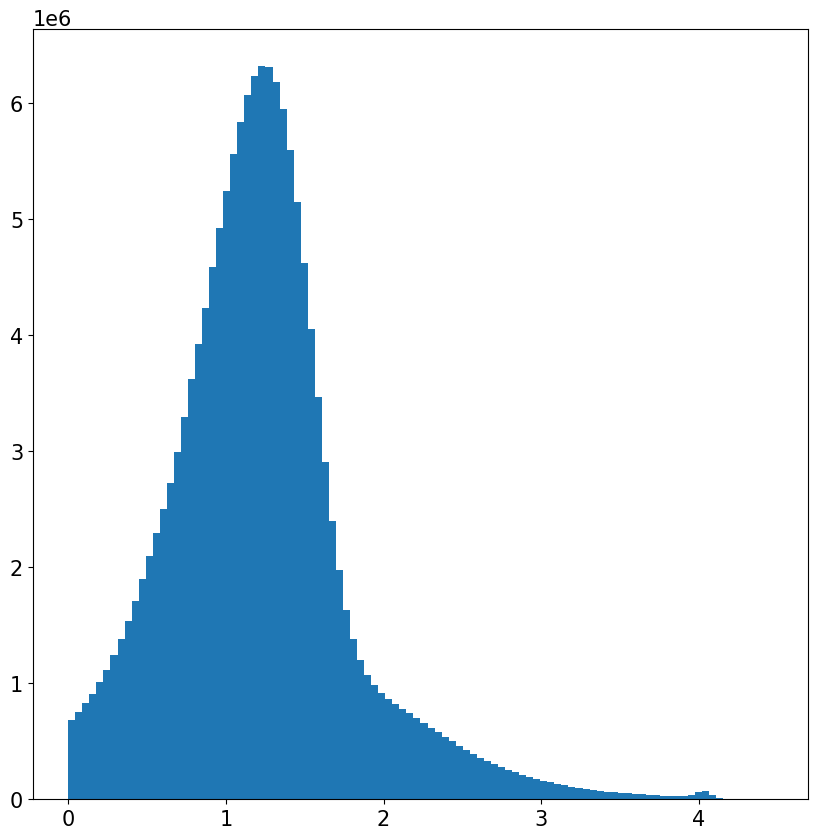

In [107]:
Traces = Dataset.get_trace_values().flatten().numpy()
Traces = Traces[Traces>1]

Traces = np.log10(Traces)

plt.figure(figsize = (10,10))
plt.hist(Traces,bins=100)
# plt.yscale('log')
